In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
import zipfile
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import pickle
from google.colab import drive

In [2]:
def configure_gpu():
    print("Checking GPU:")
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("CUDA Available:", tf.test.is_built_with_cuda())

    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=1024 * 4)]  # 4 GB
            )
            print("GPU memory configured successfully")
        except RuntimeError as e:
            print(e)

    print("\nCurrent GPU Device:")
    print(tf.test.gpu_device_name())

In [3]:
drive.mount('/content/drive')
configure_gpu()

Mounted at /content/drive
Checking GPU:
Num GPUs Available:  0
CUDA Available: True

Current GPU Device:



In [ ]:
def split_dataset(data_dir, output_base_dir, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split the dataset into train, test, and validation sets with separate folders.
    """
    train_dir = os.path.join(output_base_dir, 'train')
    test_dir = os.path.join(output_base_dir, 'test')
    val_dir = os.path.join(output_base_dir, 'validation')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]

        train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=random_state)
        train_files, val_files = train_test_split(train_files, test_size=val_size/(1-test_size), random_state=random_state)

        def copy_files(files, dest_dir):
            for file in files:
                src_path = os.path.join(class_path, file)
                dest_path = os.path.join(dest_dir, file)
                shutil.copy2(src_path, dest_path)

        copy_files(train_files, train_class_dir)
        copy_files(test_files, test_class_dir)
        copy_files(val_files, val_class_dir)

        print(f"Class {class_name}:")
        print(f"  Total images: {len(image_files)}")
        print(f"  Train images: {len(train_files)}")
        print(f"  Test images: {len(test_files)}")
        print(f"  Validation images: {len(val_files)}")

In [ ]:
def zip_dataset_splits(output_base_dir):
    """
    Zip train, test, and validation datasets
    """
    splits = ['train', 'test', 'validation']
    zip_files = []

    for split in splits:
        split_path = os.path.join(output_base_dir, split)
        zip_filename = f'{split}_dataset.zip'
        zip_path = os.path.join(output_base_dir, zip_filename)

        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(split_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, start=split_path)
                    zipf.write(file_path, arcname=os.path.join(split, arcname))

        zip_files.append(zip_path)
        print(f"Created {zip_filename}")

    return zip_files

In [ ]:
img_size = (64, 64)
severity_map = {
    'lung_aca': 1,  # Adenocarcinoma 
    'lung_n': 3,    # Large Cell Carcinoma 
    'lung_scc': 2   # Squamous Cell Carcinoma 
}

In [ ]:
def load_images_and_labels(data_dir, img_size):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

In [ ]:
# Existing feature extraction functions remain the same
def extract_histogram_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
    hist = hist / np.sum(hist)
    return hist

def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    winSize = (64, 64)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    features = hog.compute(gray)
    return features.flatten()

def extract_color_moments(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    moments = []
    for channel in range(3):
        channel_data = hsv[:,:,channel]
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        skewness = np.mean(((channel_data - mean) / std) ** 3)
        moments.extend([mean, std, skewness])
    return np.array(moments)

def extract_edge_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_count = np.sum(edges > 0)
    edge_density = edge_count / (edges.shape[0] * edges.shape[1])
    edge_mean = np.mean(edges[edges > 0])
    edge_std = np.std(edges[edges > 0])
    return np.array([edge_count, edge_density, edge_mean, edge_std])

def extract_features(images):
    all_features = []
    for image in images:
        features = []
        features.extend(extract_histogram_features(image))
        features.extend(extract_hog_features(image))
        features.extend(extract_color_moments(image))
        features.extend(extract_edge_features(image))
        all_features.append(features)
    return np.array(all_features)

In [ ]:
# Classifier Creation and Training Functions
def create_classifiers():
    classifiers = {
        'Random Forest': Pipeline([
            ('feature_selection', SelectKBest(f_classif, k=50)),
            ('classifier', RandomForestClassifier(n_estimators=100, n_jobs=-1))
        ]),
        'Gradient Boosting': Pipeline([
            ('feature_selection', SelectKBest(f_classif, k=50)),
            ('classifier', GradientBoostingClassifier(n_estimators=100))
        ]),
        'AdaBoost': Pipeline([
            ('feature_selection', SelectKBest(f_classif, k=50)),
            ('classifier', AdaBoostClassifier(n_estimators=100))
        ]),
        'SVM': Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif, k=50)),
            ('classifier', SVC(kernel='rbf', probability=True))
        ]),
        'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif, k=50)),
            ('classifier', LogisticRegression(max_iter=1000))
        ])
    }
    return classifiers

In [ ]:
def train_and_evaluate_models(data_dir, img_size):
    images, labels = load_images_and_labels(data_dir, img_size)
    X = extract_features(images)
    label_encoder = {label: idx for idx, label in enumerate(np.unique(labels))}
    y = np.array([label_encoder[label] for label in labels])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    classifiers = create_classifiers()
    os.makedirs('trained_models', exist_ok=True)
    results = {}
    for name, clf in classifiers.items():
        cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        model_path = f"trained_models/{name}.pkl"
        with open(model_path, 'wb') as f:
            pickle.dump(clf, f)
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'cv_mean_accuracy': cv_scores.mean(),
            'cv_std_accuracy': cv_scores.std(),
            'classification_report': classification_report(y_test, y_pred, target_names=list(label_encoder.keys())),
            'model_file': model_path
        }
    return results, (X_test, y_test, label_encoder)

In [ ]:
def visualize_results(results):
    accuracies = {name: res['accuracy'] for name, res in results.items()}
    cv_accuracies = {name: res['cv_mean_accuracy'] for name, res in results.items()}
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Model Test Accuracies')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.subplot(1, 2, 2)
    plt.bar(cv_accuracies.keys(), cv_accuracies.values())
    plt.title('Model Cross-Validation Accuracies')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Mean CV Accuracy')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrices(results, X_test, y_test, label_encoder):
    for name, result in results.items():
        model_path = result['model_file']
        with open(model_path, 'rb') as f:
            clf = pickle.load(f)

        y_pred = clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=list(label_encoder.keys()), yticklabels=list(label_encoder.keys()))
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

In [ ]:
import zipfile
# Method 1: Upload via Google Drive
DATA_PATH = '/content/drive/MyDrive/lung/lung.zip'  # Update this path

# Method 2: Direct upload
# uploaded = files.upload()  # This will open file picker
# DATA_PATH = list(uploaded.keys())[0]

# Extract the dataset
!mkdir -p /content/dataset
with zipfile.ZipFile(DATA_PATH, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [ ]:
original_data_dir = '/content/dataset/lung_colon_image_set/lung_image_sets'
output_base_dir = '/content/lung_cancer_dataset_split'
split_dataset(original_data_dir, output_base_dir)
# Zip the dataset splits
zip_files = zip_dataset_splits(output_base_dir)

Class lung_n:
  Total images: 5000
  Train images: 3000
  Test images: 1000
  Validation images: 1000
Class lung_aca:
  Total images: 5000
  Train images: 3000
  Test images: 1000
  Validation images: 1000
Class lung_scc:
  Total images: 5000
  Train images: 3000
  Test images: 1000
  Validation images: 1000
Created train_dataset.zip
Created test_dataset.zip
Created validation_dataset.zip


In [ ]:
from google.colab import files
for zip_file in zip_files:
      files.download(zip_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_data_dir = os.path.join(output_base_dir, 'train')
results, (X_test, y_test, label_encoder) = train_and_evaluate_models(train_data_dir, (64, 64))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0  234  235  236  237  238  239  240  241  242  243  244  245  246
  247  248  249  250  251  252  253  254  255 2031 2032] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0  234  235  236  237  238  239  240  241  242  243  244  245  246
  247  248  249  250  251  252  253  254  255 2031 2032] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f 

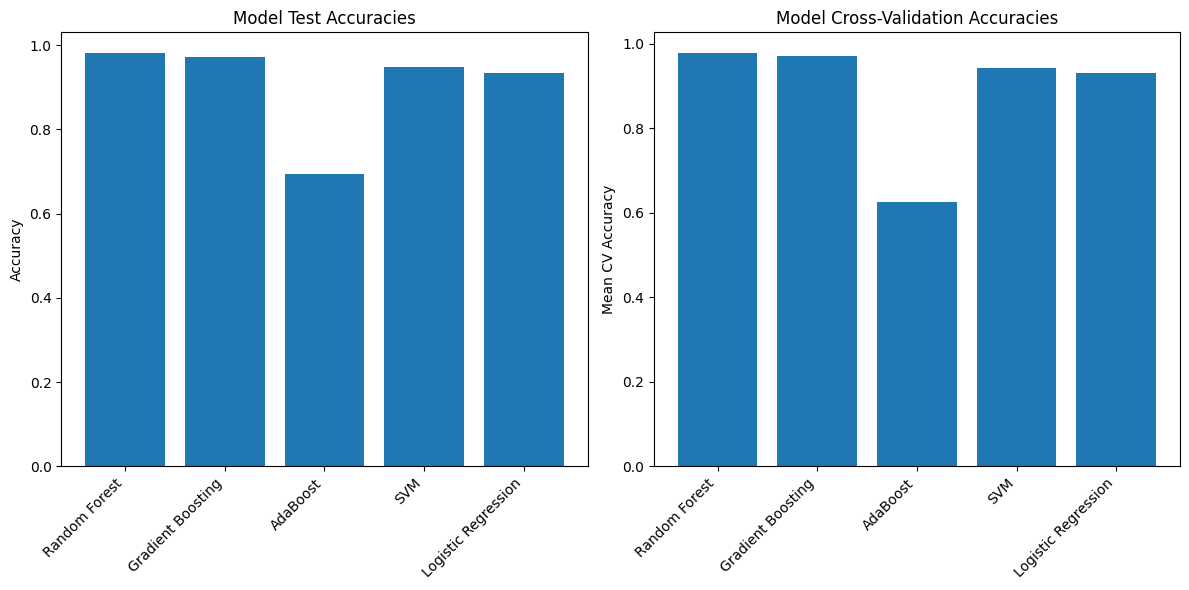

In [ ]:
visualize_results(results)

In [ ]:
print(results)

{'Random Forest': {'accuracy': 0.9811111111111112, 'cv_mean_accuracy': 0.9776388888888888, 'cv_std_accuracy': 0.002756865727955436, 'classification_report': '              precision    recall  f1-score   support\n\n    lung_aca       0.96      0.99      0.97       601\n      lung_n       1.00      0.99      1.00       585\n    lung_scc       0.99      0.96      0.97       614\n\n    accuracy                           0.98      1800\n   macro avg       0.98      0.98      0.98      1800\nweighted avg       0.98      0.98      0.98      1800\n', 'model_file': 'trained_models/Random Forest.pkl'}, 'Gradient Boosting': {'accuracy': 0.9705555555555555, 'cv_mean_accuracy': 0.9712500000000001, 'cv_std_accuracy': 0.0032453670682077444, 'classification_report': '              precision    recall  f1-score   support\n\n    lung_aca       0.95      0.97      0.96       601\n      lung_n       1.00      0.99      1.00       585\n    lung_scc       0.97      0.95      0.96       614\n\n    accuracy 

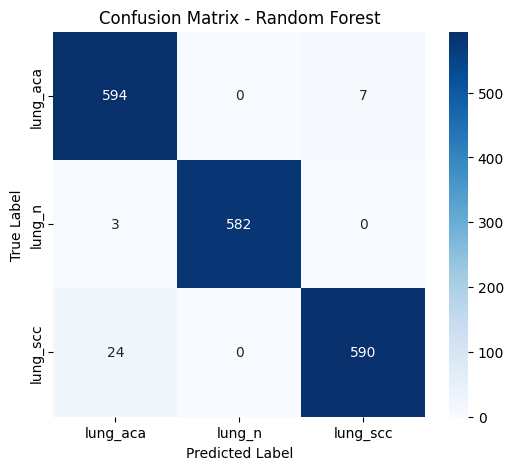

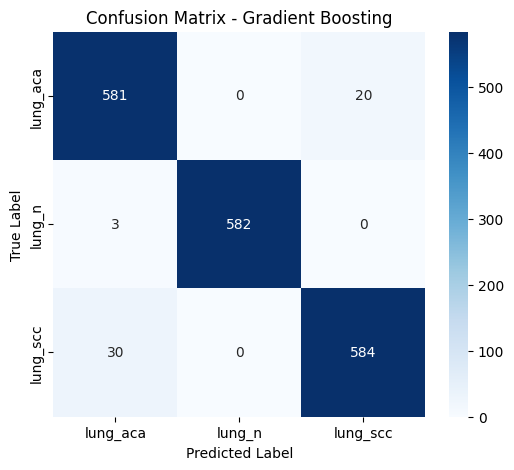

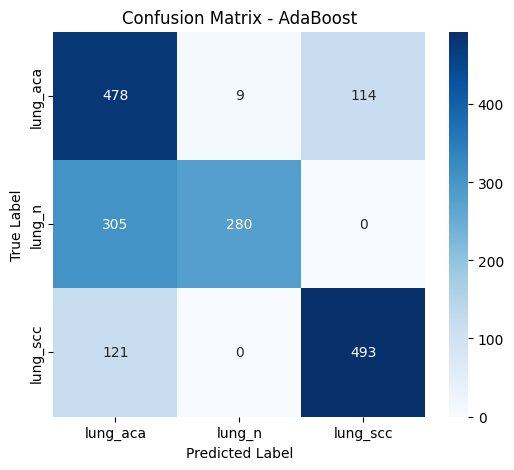

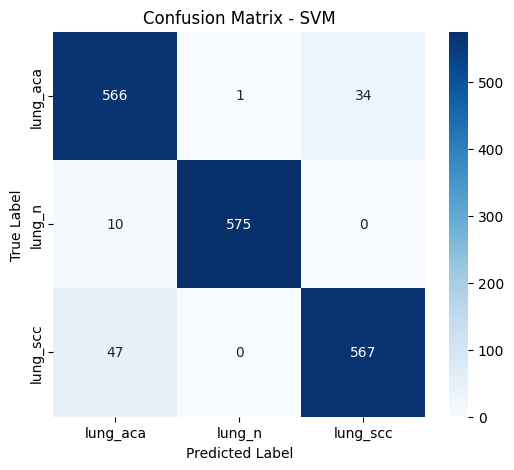

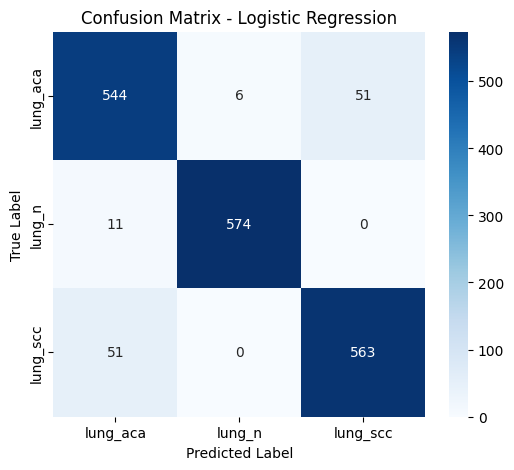

In [ ]:
plot_confusion_matrices(results, X_test, y_test, label_encoder)

In [ ]:
!zip -r trained_models.zip trained_models
files.download('trained_models.zip')

  adding: trained_models/ (stored 0%)
  adding: trained_models/Random Forest.pkl (deflated 78%)
  adding: trained_models/SVM.pkl (deflated 47%)
  adding: trained_models/Gradient Boosting.pkl (deflated 68%)
  adding: trained_models/AdaBoost.pkl (deflated 54%)
  adding: trained_models/Logistic Regression.pkl (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Code for test model with Outsourced Dataset

In [ ]:
import pickle
import os
import cv2
import numpy as np

# Function to preprocess a single image
def preprocess_image(image_path, img_size=(64, 64)):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, img_size)
        return img
    else:
        print(f"Error: Unable to load image {image_path}")
        return None

# Function to extract features (same as during training)
def extract_histogram_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
    hist = hist / np.sum(hist)
    return hist

def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    winSize = (64, 64)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    features = hog.compute(gray)
    return features.flatten()

def extract_color_moments(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    moments = []
    for channel in range(3):
        channel_data = hsv[:,:,channel]
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        skewness = np.mean(((channel_data - mean) / std) ** 3)
        moments.extend([mean, std, skewness])
    return np.array(moments)

def extract_edge_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_count = np.sum(edges > 0)
    edge_density = edge_count / (edges.shape[0] * edges.shape[1])
    edge_mean = np.mean(edges[edges > 0])
    edge_std = np.std(edges[edges > 0])
    return np.array([edge_count, edge_density, edge_mean, edge_std])

def extract_features(image, img_size=(64, 64)):
    features = []
    image = preprocess_image(image, img_size)
    if image is not None:
        features.extend(extract_histogram_features(image))
        features.extend(extract_hog_features(image))
        features.extend(extract_color_moments(image))
        features.extend(extract_edge_features(image))
        return np.array(features)
    return None

# Function to predict using the trained model
def predict_new_data(model_path, image_paths, img_size=(64, 64), label_encoder=None):
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

    predictions = []
    for image_path in image_paths:
        features = extract_features(image_path, img_size)
        if features is not None:
            features = features.reshape(1, -1)  # Ensure the features are in the right shape
            prediction = model.predict(features)
            label_decoder = {idx: label for label, idx in label_encoder.items()}
            decoded_prediction = label_decoder.get(prediction[0], "Unknown")
            predictions.append(decoded_prediction)
        else:
            predictions.append("Error: Image processing failed")

    return predictions

# Example usage
new_data_dir = "/content/lung_cancer_dataset_split/test/lung_aca/lungaca1179.jpeg"  # Update with your image path
image_paths = [new_data_dir]  # Add more images to the list if needed
model_path = "trained_models/Random Forest.pkl"  # Path to your trained model file
label_encoder = {"lung_aca": 0, "lung_n": 1, "lung_scc": 2}  # Example label encoder; update if necessary
predictions = predict_new_data(model_path, image_paths, img_size=(64, 64), label_encoder=label_encoder)
print("Predicted Labels:", predictions)

Predicted Labels: ['lung_aca']
